# Installing Requirements + Setup
Goal of this Hackathon: **Classify digits (0-9) from a diverse dataset of handwritten, printed, and billboard text**

In [ ]:
!pip install datasets transformers torch albumentations
!sudo apt install zstd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zstd is already the newest version (1.4.4+dfsg-3ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset
https://drive.google.com/drive/folders/1s51ff8PCpqPkum9bgGQPcHV6So2vlDOx?usp=share_link

In [ ]:
!cp -r /content/drive/MyDrive/'Colab Notebooks'/Hack5-Signal/filtered_signal_resize ./

In [ ]:
!pip install pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


# Preprocessing Dataset + Augmentation


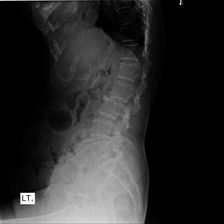

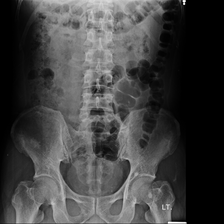

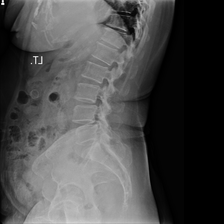

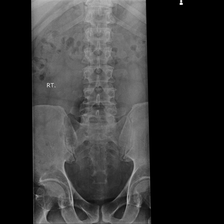

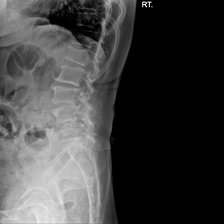

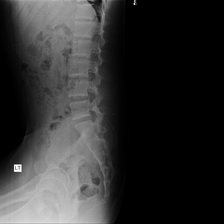

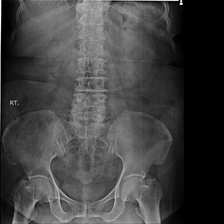

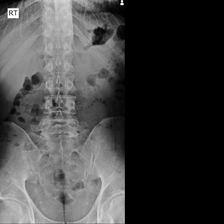

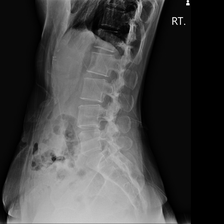

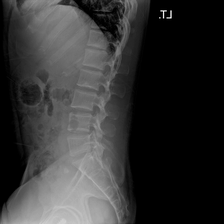

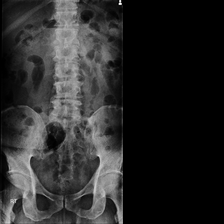

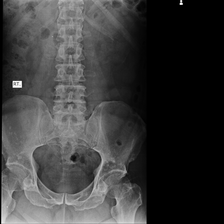

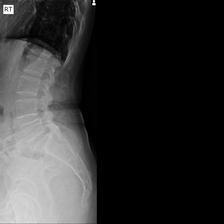

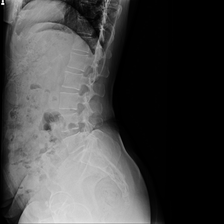

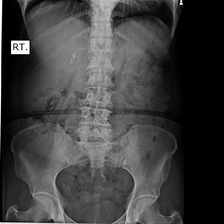

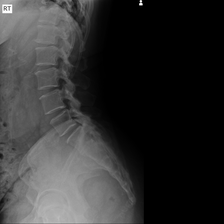

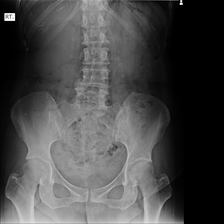

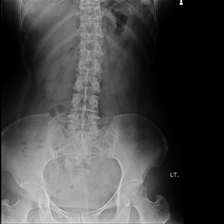

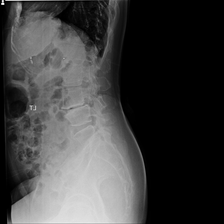

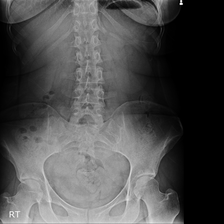

In [ ]:
import glob
import random
from PIL import Image, ImageOps
import albumentations as A
import numpy as np

files = glob.glob("/content/BUU-LSPINE_gender/train/**/*.jpg", recursive=True)

augment = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.RGBShift(p=0.25),
    A.ColorJitter(p=0.25),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

size = 224

for _ in range(20):
    # Test Transformations
    choice = random.choice(files)
    img = Image.open(choice)
    img = ImageOps.contain(img, (size, size), Image.Resampling.LANCZOS).convert("RGB")
    img = ImageOps.autocontrast(img)
    # img = augment(image=np.array(img))["image"].astype(np.uint8)

    # img = Image.fromarray(img)

    img = ImageOps.pad(img, (size, size), centering=(0,0))

    # img = ImageOps.grayscale(img)

    # img = ImageOps.autocontrast(img)
    display(img)

# Loading Processed Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/BUU-LSPINE_gender/train")

Resolving data files:   0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data = dataset["train"].train_test_split(test_size=0.15)

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2720
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 480
    })
})

# Initialize Training
I chose ViT for this as it is one of the state-of-the art models at this time.
The rationale behind choosing the variant finetuned on the imagenet as well was to perhaps harness the benefits of transfer learning. Unfortunately, I was not able to validate this hypothesis as there was not enough time.

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name_or_path = 'google/vit-large-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

labels = data['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-large-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model 

In [ ]:
labels

['F', 'M']

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def process_example(example):
    example["image"] = example["image"]
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
def _transform(example_batch):
    IMG_SIZE = 224
    new_imgs = []
    for img in example_batch:
        image = ImageOps.contain(img, (IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS).convert("RGB")
        image = ImageOps.autocontrast(image)

        # image = augment(image=np.array(image))["image"].astype(np.uint8)
        # image = Image.fromarray(image)

        image = ImageOps.pad(image, (IMG_SIZE, IMG_SIZE), centering=(0, 0))
        new_imgs.append(image)
    return new_imgs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in _transform(example_batch['image'])], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [ ]:
prepared_data = data.with_transform(transform)

In [ ]:
import torch
import numpy as np
from datasets import load_metric

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


acc = load_metric("accuracy")
f1 = load_metric("f1")

def compute_metrics(p):
    info = {}

    preds = np.argmax(p.predictions, axis=1)
    info["accuracy"] = acc.compute(predictions=preds, references=p.label_ids)["accuracy"]
    info["f1"] = f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]

    return info


<ipython-input-12-65140206de28>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  acc = load_metric("accuracy")


In [ ]:

import os
os.kill(os.getpid(), 9)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-gender-processing-noimgnet",
  per_device_train_batch_size=128,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=8,
  fp16=True,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  warmup_ratio=0.1,
  remove_unused_columns=False,
  push_to_hub=False,
  metric_for_best_model="accuracy",
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_data["train"],
    eval_dataset=prepared_data["test"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2759 in training_step            │
│                                                                                                  │
│   2756 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2757 │   │                                                                                     │
│   2758 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2759 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2760 │   │                                                                                     │
│   2761 │   │   if self.args.n_gpu > 1:                                                           │
│   2762 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2784 in compute_loss             │
│                                                                                                  │
│   2781 │   │   │   labels = inputs.pop("labels")                                                 │
│   2782 │   │   else:                                                                             │
│   2783 │   │   │   labels = None                                                                 │
│ ❱ 2784 │   │   outputs = model(**inputs)                                                         │
│   2785 │   │   # Save past state if it exists              

In [ ]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         15.0
  total_flos               = 2944537602GF
  train_loss               =       0.0377
  train_runtime            =   1:02:14.47
  train_samples_per_second =       10.925
  train_steps_per_second   =        0.088


In [ ]:
metrics = trainer.evaluate(prepared_data["test"])

In [ ]:
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.9521
  eval_f1                 =     0.9488
  eval_loss               =      0.279
  eval_runtime            = 0:00:37.54
  eval_samples_per_second =     12.785
  eval_steps_per_second   =      1.598


In [ ]:
# Confusion Matrix
import torch
import torch.nn.functional as F
from sklearn import metrics
import copy

y_preds = []
y_trues = []
for index,val_item in enumerate(data["test"]):
     encoding = feature_extractor(_transform([val_item["image"]])[0], return_tensors="pt").to("cuda")
     outputs = model(**encoding)
     y_pred = outputs.logits.argmax(-1)
     y_true = val_item["label"]
     y_preds.append(y_pred)
     y_trues.append(y_true)
    #  print(f"{index} out of {len(data['test'])}")


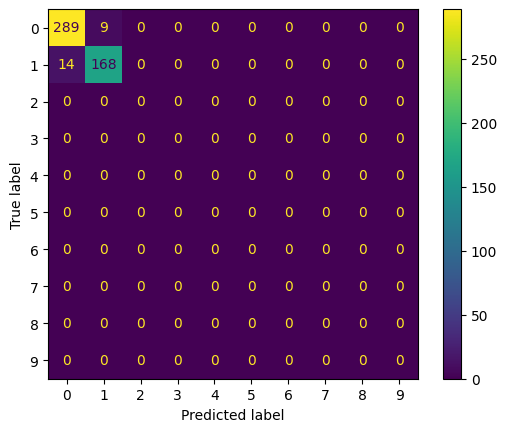

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix([int(x) for x in y_trues], [x.item() for x in y_preds], labels=[x for x in range(10)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
!cp -r "vit-digit-recognition/checkpoint-16488" drive/MyDrive/vit/

cp: cannot stat 'vit-digit-recognition/checkpoint-16488': No such file or directory


In [ ]:
!zip -r "checkpoint-16488.zip" "vit-digit-recognition/checkpoint-16488"

	zip warning: name not matched: vit-digit-recognition/checkpoint-16488

zip error: Nothing to do! (try: zip -r checkpoint-16488.zip . -i vit-digit-recognition/checkpoint-16488)


# Get Results
The test files can have many digits in one photo, so we first crop these according to the bounding boxes given.

In [ ]:
test_images = glob.glob("/content/BUU-LSPINE_gender/test/*")
test_images

['/content/BUU-LSPINE_gender/test/605.jpg',
 '/content/BUU-LSPINE_gender/test/513.jpg',
 '/content/BUU-LSPINE_gender/test/61.jpg',
 '/content/BUU-LSPINE_gender/test/698.jpg',
 '/content/BUU-LSPINE_gender/test/400.jpg',
 '/content/BUU-LSPINE_gender/test/35.jpg',
 '/content/BUU-LSPINE_gender/test/502.jpg',
 '/content/BUU-LSPINE_gender/test/83.jpg',
 '/content/BUU-LSPINE_gender/test/578.jpg',
 '/content/BUU-LSPINE_gender/test/529.jpg',
 '/content/BUU-LSPINE_gender/test/460.jpg',
 '/content/BUU-LSPINE_gender/test/151.jpg',
 '/content/BUU-LSPINE_gender/test/617.jpg',
 '/content/BUU-LSPINE_gender/test/239.jpg',
 '/content/BUU-LSPINE_gender/test/99.jpg',
 '/content/BUU-LSPINE_gender/test/501.jpg',
 '/content/BUU-LSPINE_gender/test/483.jpg',
 '/content/BUU-LSPINE_gender/test/616.jpg',
 '/content/BUU-LSPINE_gender/test/328.jpg',
 '/content/BUU-LSPINE_gender/test/22.jpg',
 '/content/BUU-LSPINE_gender/test/57.jpg',
 '/content/BUU-LSPINE_gender/test/182.jpg',
 '/content/BUU-LSPINE_gender/test/49.j

In [ ]:
from PIL import Image, ImageOps
import torch

answers_final = dict()

with torch.no_grad():
    for img_id, image_path in enumerate(test_images):
        key = image_path.split("/")[-1]

        img = Image.open(image_path)

        # Transform those images
        image = ImageOps.contain(img, (224, 224), Image.Resampling.LANCZOS).convert("RGB")
        image = ImageOps.autocontrast(image)
        image = ImageOps.pad(image, (224, 224), centering=(0, 0))

        encoding = feature_extractor(image, return_tensors="pt").to("cuda")
        outputs = model(**encoding)
        pred = outputs.logits.argmax(-1).item()
        answers_final[f"{key.split('.')[0]}"] = model.config.id2label[str(pred)]

answers_final

{'605': 'F',
 '513': 'F',
 '61': 'F',
 '698': 'F',
 '400': 'M',
 '35': 'F',
 '502': 'F',
 '83': 'F',
 '578': 'M',
 '529': 'F',
 '460': 'M',
 '151': 'F',
 '617': 'F',
 '239': 'F',
 '99': 'M',
 '501': 'F',
 '483': 'M',
 '616': 'F',
 '328': 'M',
 '22': 'F',
 '57': 'F',
 '182': 'F',
 '49': 'F',
 '159': 'F',
 '100': 'F',
 '386': 'M',
 '701': 'M',
 '791': 'M',
 '284': 'F',
 '562': 'F',
 '786': 'F',
 '97': 'F',
 '282': 'F',
 '374': 'M',
 '409': 'F',
 '527': 'M',
 '260': 'F',
 '742': 'F',
 '218': 'F',
 '225': 'F',
 '691': 'F',
 '85': 'M',
 '295': 'M',
 '300': 'F',
 '777': 'F',
 '478': 'F',
 '15': 'F',
 '273': 'F',
 '330': 'M',
 '346': 'F',
 '661': 'M',
 '227': 'F',
 '758': 'F',
 '435': 'M',
 '388': 'M',
 '7': 'F',
 '566': 'F',
 '167': 'F',
 '350': 'F',
 '569': 'M',
 '395': 'M',
 '131': 'F',
 '86': 'F',
 '677': 'F',
 '242': 'F',
 '443': 'F',
 '145': 'F',
 '535': 'M',
 '27': 'F',
 '796': 'F',
 '314': 'F',
 '8': 'F',
 '436': 'F',
 '396': 'F',
 '663': 'M',
 '387': 'M',
 '610': 'F',
 '761': 'F',
 '

In [ ]:
with open("solution_vit_no_pretrained-dsf.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name}.jpg,{answers_final[name]}\n")